KUTUPHANELERIN IMPORT EDILMESI

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from decimal import getcontext
import warnings
from sklearn.metrics import accuracy_score

### Datayı Düzenlemek İçin Yazılan Fonksiyon

In [3]:
def first_edit(dataframe):
    """
    Tum küçük harfleri büyük harf yapar.
    Değişken isimlerindeki türkçe karakterleri atar.
    Verideki sutun isimlerini standartlaştırır.
    """
    dataframe.columns = [col.upper() for col in dataframe.columns]
    dataframe.columns = dataframe.columns.str.replace(' ', '_')
    dataframe.columns = dataframe.columns.str.replace('İ', 'I')
    dataframe.columns = dataframe.columns.str.replace('Ğ', 'G')
    dataframe.columns = dataframe.columns.str.replace('Ö', 'O')
    dataframe.columns = dataframe.columns.str.replace('Ü', 'U')
    dataframe.columns = dataframe.columns.str.replace('Ş', 'S')
    dataframe.columns = dataframe.columns.str.replace('Ç', 'C')
    return dataframe

### Tahmin Listesini Yarışmanın İstediği Formata Dönüştüren Fonksiyon


In [4]:
def sample_sub(y_pred):
  newlist = ["obek_" + str(item + 1) for item in y_pred]

  submission = pd.DataFrame({"id": range(0, 2340),
                           "Öbek İsmi": newlist})
  return submission

### Veriyi Analiz Etmek İçin Kullanılacak Fonksiyonlar

In [5]:
def check_df(dataframe, head=5, non_numeric=True):
    """
    Veri setinin genel özellikleirni yazdirir.
    non_numeric değişken veri setinde kategorik değişken varsa false yapılmalıdır.

    """
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### DESCRIBE #####################")
    print(dataframe.describe())
    if non_numeric:
        print("##################### Quantiles #####################")
        print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


def cat_summary(dataframe, cat_col, plot=False):
    """
        Kategorik kolonlar input olarak verilmelidir.
        Sadece ekrana cikti veren herhangi bir degeri return etmeyen bir fonksiyondur.
        For dongusuyle calistiginda grafiklerde bozulma olmamktadir.
    """
    print(pd.DataFrame({cat_col: dataframe[cat_col].value_counts(),
                        "Ratio": 100 * dataframe[cat_col].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[cat_col], data=dataframe)
        plt.show(block=True)

def num_summary(dataframe, numerical_col, plot=False):
    """
        Numerik kolonlar input olarak verilmelidir.
        Sadece ekrana cikti veren herhangi bir degeri return etmeyen bir fonksiyondur.
        For dongusuyle calistiginda grafiklerde bozulma olmamaktadir.
    """
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

### Değişkenleri Tiplerine Göre Ayırmamızı Sağlayan Fonksiyon

In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenleri de dahil eder.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols

### Outlier Fonksiyonları

In [7]:
def grab_outliers(dataframe, num_col_name, index=False, q1=0.10, q3=0.90):
    """
    Bir dataframe için numerik kolonların kendi içerisinde outlier incelemesini yapar.
    for ile numerik değişkenlerin sırasıyla verilmesi ile çalışır.
    Parametrelerden index değişkeni true yapılırsa fonksiyon outlier varsa True return eder.
    q1 ve q3 değerleri düşük tutularak verinin doğal yapısını bozmamak amaçlanmıştır. Bu değerler isteğe bağlı değiştririlebilir.
    """

    quartile1 = dataframe[num_col_name].quantile(q1)
    quartile3 = dataframe[num_col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range

    if dataframe[(dataframe[num_col_name] > up_limit) | (dataframe[num_col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def diffrent_outlier(df, num_col_name, target, std1=3, std2=3):
    """
    grab_outliers fonksiyonu sadece sutun sutun inceleme yaptığı için bazı outlier'ların yakalanmadığı anlaşılmıştır.
    Bu fonksiyon numerik kolonları for döngüsüyle sırasıyla alır ve obek ismine göre outlier taraması yapar.
    Outlier değerlerin indekslerini liste olarak döndürür.

    """
    dict = {}
    outlier_indices = []

    for obek in df[target].unique():
        selected_obek = df[df[target] == obek]
        selected_col = selected_obek[num_col_name]

        std = selected_col.std()
        avg = selected_col.mean()

        three_sigma_plus = avg + (std1 * std)
        three_sigma_minus = avg - (std2 * std)

        outlier_count = (selected_obek[num_col_name] > three_sigma_plus).sum() + (selected_obek[num_col_name]< three_sigma_minus).sum()
        dict.update({obek: outlier_count})

        outliers = selected_obek[(selected_col > three_sigma_plus) | (selected_col < three_sigma_minus)]
        outlier_indices.extend(outliers.index.tolist())
    print(f"\n{num_col_name} Kolonundaki öbeklere göre outlier sayısı : ")
    print(dict)
    print(f"{num_col_name} Kolonundaki toplam outlier sayısı : {sum(list(dict.values()))}")
    print("##############################\n")
    return outlier_indices



## Hadi Başlayalım

Görünüm Ayarlarını Yapalım

In [8]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 700)

# Tüm uyarıları geçici olarak filtrelemek
warnings.filterwarnings("ignore")

# Virgülden sonra kaç basamak gösterileceğini ayarla
getcontext().prec = 5

CSV dosyasını içeri aktaralım ve işlemlere başlayalım

In [9]:
train_df = pd.read_csv("train.csv")

Veri hakkında bilgi edinmek için checkdf fonksiyonunu çalıştıralım

In [10]:
check_df(train_df, non_numeric=False)

##################### Shape #####################
(5460, 14)
##################### Types #####################
index                                           int64
Cinsiyet                                       object
Yaş Grubu                                      object
Medeni Durum                                   object
Eğitim Düzeyi                                  object
İstihdam Durumu                                object
Yıllık Ortalama Gelir                         float64
Yaşadığı Şehir                                 object
En Çok İlgilendiği Ürün Grubu                  object
Yıllık Ortalama Satın Alım Miktarı            float64
Yıllık Ortalama Sipariş Verilen Ürün Adedi    float64
Eğitime Devam Etme Durumu                      object
Öbek İsmi                                      object
Yıllık Ortalama Sepete Atılan Ürün Adedi      float64
dtype: object
##################### Head #####################
   index Cinsiyet Yaş Grubu Medeni Durum         Eğitim Düzeyi        

## İlk Düzenlemeler

Veride NA değeri olmadığı, değişkenlerin boşluk içerdiği ve harflerin büyük harf küçük harf şeklinde gittiği görülmüştür. Düzenlemeleri yapalım ve INDEX değişkenini verinin içinden atalım.

In [11]:
train_df = first_edit(train_df)
train_df.drop("INDEX", axis=1, inplace = True)

Yaptığımız değişikliği kontrol edelim.

In [12]:
print(train_df.head())
print(train_df.tail())

  CINSIYET YAS_GRUBU MEDENI_DURUM         EGITIM_DUZEYI                 ISTIHDAM_DURUMU  YILLIK_ORTALAMA_GELIR YASADIGI_SEHIR     EN_COK_ILGILENDIGI_URUN_GRUBU  YILLIK_ORTALAMA_SATIN_ALIM_MIKTARI  YILLIK_ORTALAMA_SIPARIS_VERILEN_URUN_ADEDI EGITIME_DEVAM_ETME_DURUMU OBEK_ISMI  YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI
0    Kadın     31-40        Bekar  Yüksek Lisans Mezunu  Düzenli ve Ücretli Bir İşi Var          748266.440879    Büyük Şehir  Elektronik ve Teknolojik Ürünler                        32010.900881                                   37.310644                   Etmiyor    obek_4                                102.936904
1    Erkek       >60         Evli           Lise Mezunu             Kendi İşinin Sahibi          246298.609605    Küçük Şehir                  Spor Malzemeleri                         4145.729891                                   11.554851                   Etmiyor    obek_5                                 82.176053
2    Erkek     18-30        Bekar           Li

Değişkenleri Tiplerine Göre Ayıralım (Kategorik Numerik).

In [13]:
cat_cols, num_cols = grab_col_names(train_df)

Observations: 5460
Variables: 13
cat_cols: 9
num_cols: 4
cat_but_car: 0
num_but_cat: 0


## Outlier

Temel Outlier İncelemesi Yapalım.

In [14]:
for col in num_cols:
  print(f"{col} Kolonunda outlier var mı ? {grab_outliers(train_df,col)}")

YILLIK_ORTALAMA_GELIR Kolonunda outlier var mı ? False
YILLIK_ORTALAMA_SATIN_ALIM_MIKTARI Kolonunda outlier var mı ? False
YILLIK_ORTALAMA_SIPARIS_VERILEN_URUN_ADEDI Kolonunda outlier var mı ? False
YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI Kolonunda outlier var mı ? False


Grab_outliers fonksiyonu her sütun için outlier incelemesi yapacak şekilde çalıştırıldı. Ama her sütunun kendi dağılımı içerisinde bu aramayı yaptı. Bu bize yeterli gelmediği için farklı bir outlier fonksiyonuyla öbek ismine göre outlier araması yapacağız.

Diffrent outlier fonksiyonu öbek ismine göre tüm sayısal değişkenler için outlier bulur. Bulunan değerler birbirleriyle kesişebilir.

In [15]:
indices = []
"""
-Yaptığımız testler sonucu normal dağılım grafiğine göre outlier tespit eden
  fonksiyonumuzun standart sapma katsayısının en yüksek accuracy veren değerini
  3.8 olarak bulduk.
"""
for col in num_cols:
    indices.extend(diffrent_outlier(train_df, col,"OBEK_ISMI", std1=3.8, std2=3.8))
indices = set(indices)
print(f"outlier sayısı {len(indices)} ")

# Elde ettiğimiz indisleri datadan drop edelim:
train_df.drop(indices, inplace=True)


YILLIK_ORTALAMA_GELIR Kolonundaki öbeklere göre outlier sayısı : 
{'obek_4': 0, 'obek_5': 8, 'obek_8': 6, 'obek_3': 1, 'obek_6': 17, 'obek_1': 8, 'obek_7': 8, 'obek_2': 9}
YILLIK_ORTALAMA_GELIR Kolonundaki toplam outlier sayısı : 57
##############################


YILLIK_ORTALAMA_SATIN_ALIM_MIKTARI Kolonundaki öbeklere göre outlier sayısı : 
{'obek_4': 26, 'obek_5': 10, 'obek_8': 10, 'obek_3': 14, 'obek_6': 17, 'obek_1': 17, 'obek_7': 20, 'obek_2': 14}
YILLIK_ORTALAMA_SATIN_ALIM_MIKTARI Kolonundaki toplam outlier sayısı : 128
##############################


YILLIK_ORTALAMA_SIPARIS_VERILEN_URUN_ADEDI Kolonundaki öbeklere göre outlier sayısı : 
{'obek_4': 18, 'obek_5': 14, 'obek_8': 15, 'obek_3': 11, 'obek_6': 12, 'obek_1': 13, 'obek_7': 13, 'obek_2': 4}
YILLIK_ORTALAMA_SIPARIS_VERILEN_URUN_ADEDI Kolonundaki toplam outlier sayısı : 100
##############################


YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI Kolonundaki öbeklere göre outlier sayısı : 
{'obek_4': 16, 'obek_5': 12, 'obe

Outlierlardan emin olmak için bir de Local Outlier Factor kullandık.

In [16]:
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(train_df[num_cols])
df_scores = clf.negative_outlier_factor_

print(df_scores)

[-1.04220036 -0.98116145 -1.05831649 ... -1.01047011 -1.06639656
 -1.00522111]


Local Outilier Factor için görselleştirme yaptık. Bu grafikte kırılımı daha net bir şekilde gördük.

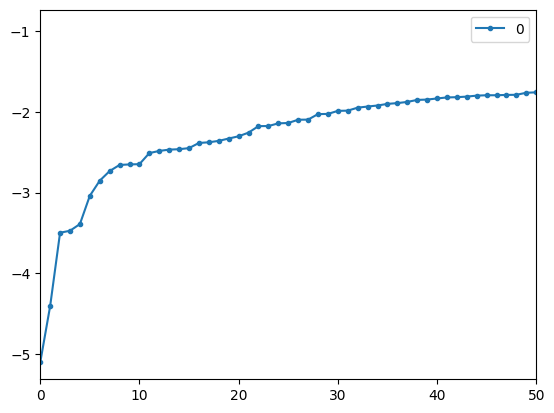

In [17]:
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 50], style='.-')
plt.show()

Yukardai grafikten görüleceği üzere 3. noktadan sonra verideki değişimlerin daha stabil olduğu ama o noktadan önce değişimlerin kararsız olduğu görülmüştür. Bundan dolayı ilk 3 gözlem drop edilmiştir.

In [18]:
th = np.sort(df_scores)[3]

lof_drop_index = train_df[df_scores < th].index

train_df.drop(lof_drop_index, inplace=True)

print(lof_drop_index)

Index([4395, 4999, 5130], dtype='int64')


Veride outlier incelemesi yapıldı. Veriyi ilk incelememiz ve testlerimiz sırasında daha fazla outlier değeri veriden drop edilmişti. Lakin bir sonraki aşamada anlayacağımız üzere train setindeki outlierların benzerleri test setinde de bulunmaktalar. Bu sebeple rassallığı bozmamak için bütün outlierların atılmaması daha doğru bulundu. Sadece aşırı uçlarda bulunan outlierlar modeli desteklemek için veriden atıldı. Aşağıya outlier değerlerinden kurtulmak için yazmış olduğumuz ama testler sonrasında modeli bozduğunu düşündüğümüz standart sapmaya dayalı olarak outlier hesaplaması yapan fonksiyonu da ekliyoruz.

In [18]:
def quantile_outlier(dataframe,num_cols,target):

    outlier_indices = []

    for col_name in num_cols:
        for obek in dataframe[target].unique():
            selected_obek = dataframe[dataframe[target] == obek]
            selected_col = selected_obek[col_name]

            q1 = selected_col.quantile(0.01)
            q3 = selected_col.quantile(0.99)

            iqr = q3 - q1

            minimum = q1 - (1.5 * iqr)
            maximum = q3 + (1.5 * iqr)

            # print(col_name, obek, " | min= ", minimum, "max= ", maximum)

            max_indx = dataframe[(dataframe[target] == obek) & (dataframe[col_name] > maximum)].index
            min_indx = dataframe[(dataframe[target] == obek) & (dataframe[col_name] < minimum)].index
            # print(max_indx)
            # print(max_indx)

            outlier_indices.extend(max_indx.tolist())
            outlier_indices.extend(min_indx.tolist())

    return outlier_indices

## Veri Görselleştirme ve Keşifçi Veri Analizi

Kategorik ve numerik değişkenlerin grafiklerini çizdirelim standart sapma medyan ortalama gibi özel değerleri sutunlar için bulalım ve inceleyelim.

count    5.265000e+03
mean     3.628143e+05
std      2.189178e+05
min      4.569509e+04
5%       1.507235e+05
10%      1.705182e+05
20%      2.032388e+05
30%      2.273178e+05
40%      2.514705e+05
50%      2.865681e+05
60%      3.434865e+05
70%      3.720616e+05
80%      4.842017e+05
90%      7.574460e+05
95%      8.889928e+05
99%      1.034977e+06
max      1.192437e+06
Name: YILLIK_ORTALAMA_GELIR, dtype: float64


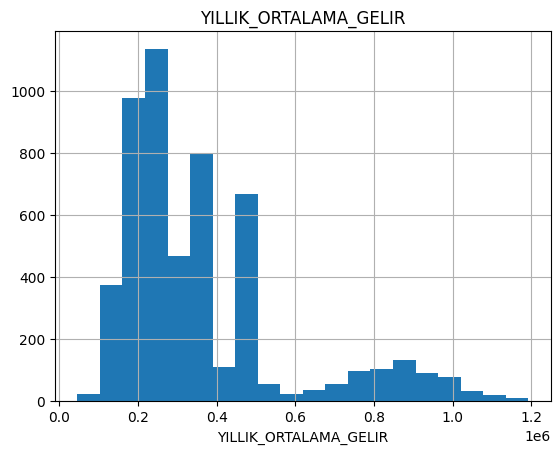

count     5265.000000
mean     16581.223649
std      14097.940481
min       2859.254000
5%        3749.653779
10%       3981.244022
20%       4469.966311
30%       5419.071782
40%       6490.589711
50%       8401.418563
60%       9636.125407
70%      27927.278302
80%      33288.847866
90%      38745.887926
95%      41217.400477
99%      44086.772013
max      48605.594415
Name: YILLIK_ORTALAMA_SATIN_ALIM_MIKTARI, dtype: float64


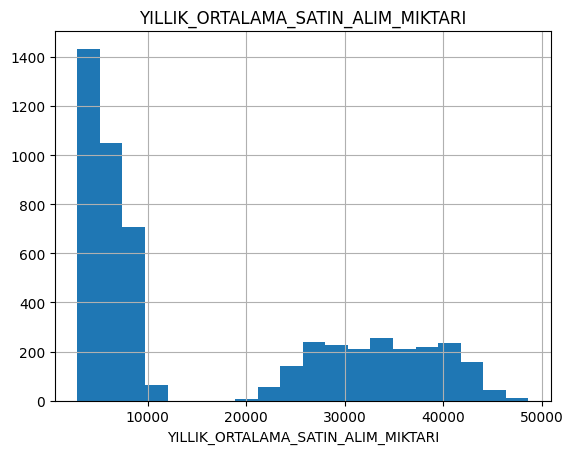

count    5265.000000
mean       24.048373
std        14.953170
min         0.000000
5%          4.016181
10%         7.173958
20%        10.318420
30%        14.265138
40%        16.356440
50%        20.134017
60%        26.228211
70%        31.191045
80%        39.672256
90%        46.764711
95%        51.817808
99%        57.697485
max        64.616196
Name: YILLIK_ORTALAMA_SIPARIS_VERILEN_URUN_ADEDI, dtype: float64


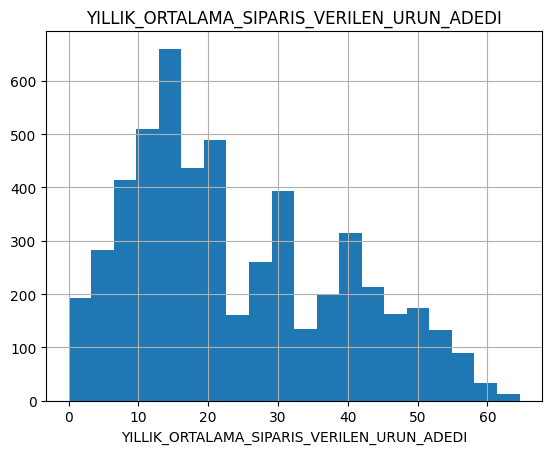

count    5265.000000
mean       73.428398
std        47.180673
min         3.977559
5%          9.502425
10%        11.482573
20%        20.339352
30%        43.384976
40%        51.701307
50%        82.250450
60%        94.874733
70%       101.249231
80%       108.675909
90%       129.487015
95%       158.986874
99%       192.467093
max       242.308441
Name: YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI, dtype: float64


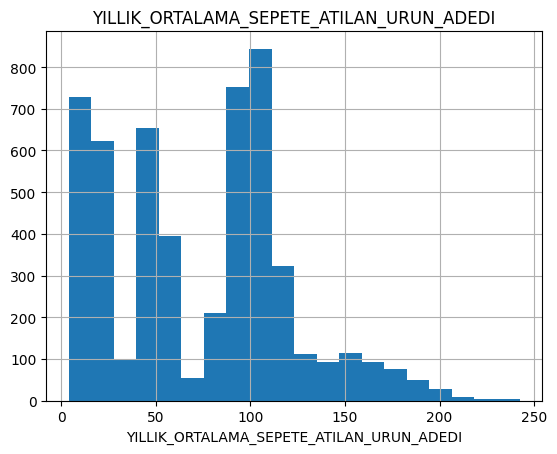

In [19]:
for num_col in num_cols:
  num_summary(train_df,num_col,plot=True)

          CINSIYET      Ratio
CINSIYET                     
Erkek         2854  54.207028
Kadın         2411  45.792972
##########################################


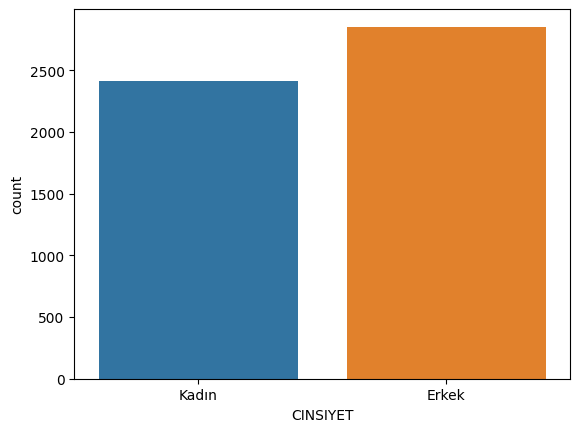

           YAS_GRUBU      Ratio
YAS_GRUBU                      
18-30           1776  33.732194
31-40           1422  27.008547
51-60            824  15.650522
41-50            704  13.371320
>60              539  10.237417
##########################################


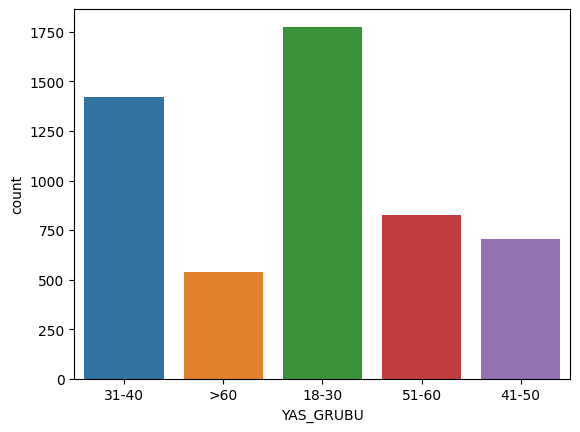

              MEDENI_DURUM      Ratio
MEDENI_DURUM                         
Evli                  2732  51.889839
Bekar                 2533  48.110161
##########################################


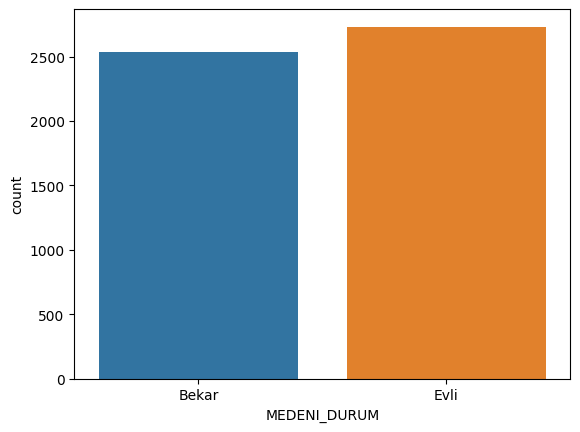

                      EGITIM_DUZEYI      Ratio
EGITIM_DUZEYI                                 
Lise Mezunu                    1346  25.565052
Üniversite Mezunu              1209  22.962963
Yüksekokul Mezunu               566  10.750237
Yüksek Lisans Mezunu            523   9.933523
İlkokul Mezunu                  408   7.749288
Ortaokul Mezunu                 398   7.559354
Eğitimsiz                       366   6.951567
Doktora Mezunu                  254   4.824311
Doktora Ötesi                   195   3.703704
##########################################


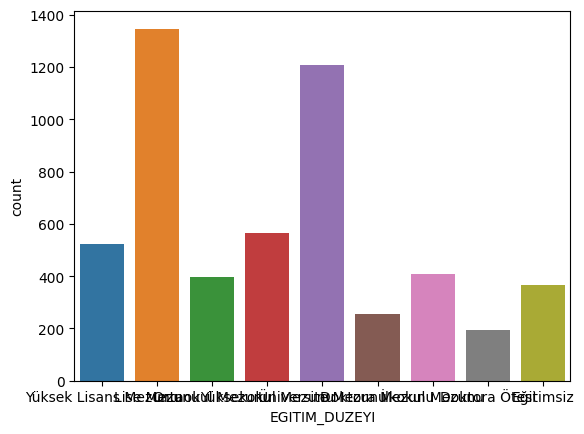

                                ISTIHDAM_DURUMU      Ratio
ISTIHDAM_DURUMU                                           
Düzenli ve Ücretli Bir İşi Var             2668  50.674264
İşsiz veya Düzenli Bir İşi Yok             1301  24.710351
Kendi İşinin Sahibi                         846  16.068376
Emekli                                      450   8.547009
##########################################


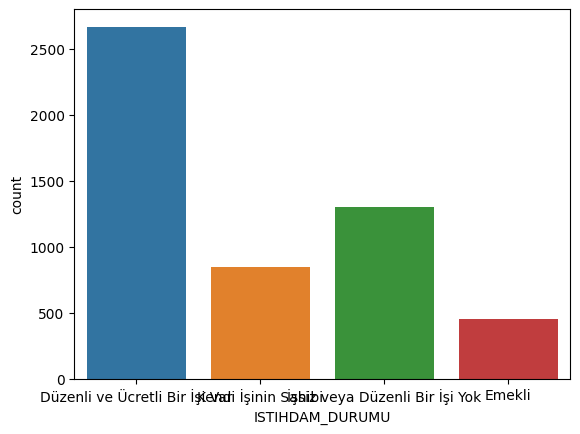

                 YASADIGI_SEHIR      Ratio
YASADIGI_SEHIR                            
Büyük Şehir                1871  35.536562
Küçük Şehir                1789  33.979107
Köy veya Kasaba            1057  20.075973
Kırsal                      548  10.408357
##########################################


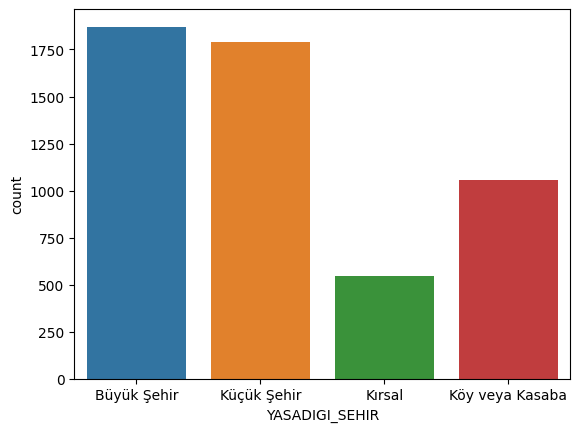

                                  EN_COK_ILGILENDIGI_URUN_GRUBU      Ratio
EN_COK_ILGILENDIGI_URUN_GRUBU                                             
Giyim                                                      1428  27.122507
Ev ve Mobilya                                              1079  20.493827
Elektronik ve Teknolojik Ürünler                            996  18.917379
Spor Malzemeleri                                            956  18.157645
Kozmetik                                                    806  15.308642
##########################################


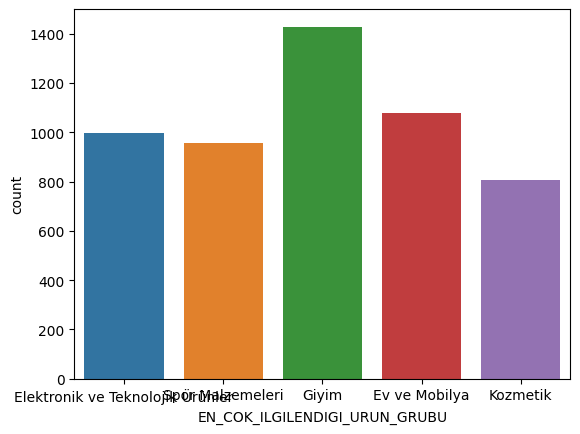

                           EGITIME_DEVAM_ETME_DURUMU      Ratio
EGITIME_DEVAM_ETME_DURUMU                                      
Etmiyor                                         4389  83.361823
Ediyor                                           876  16.638177
##########################################


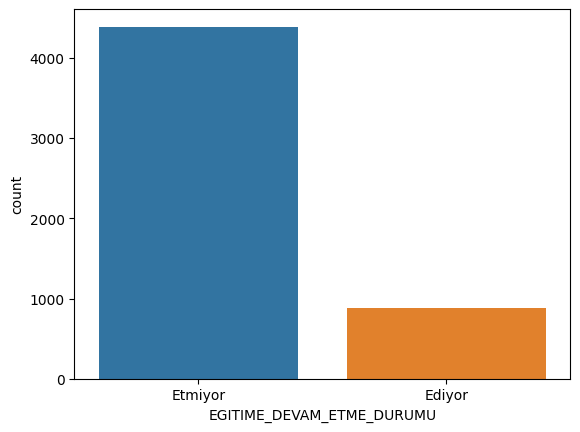

           OBEK_ISMI      Ratio
OBEK_ISMI                      
obek_4           694  13.181387
obek_8           693  13.162393
obek_5           681  12.934473
obek_3           675  12.820513
obek_1           667  12.668566
obek_6           664  12.611586
obek_7           663  12.592593
obek_2           528  10.028490
##########################################


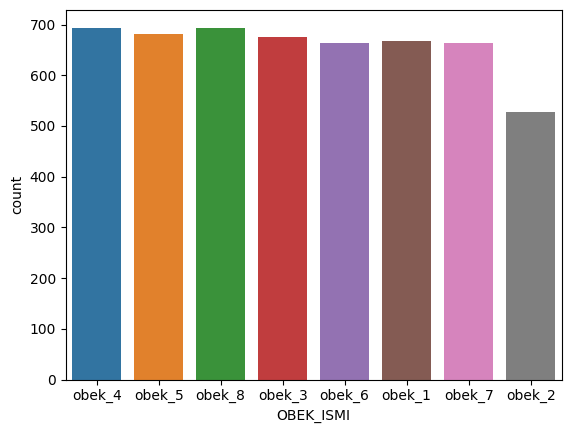

In [20]:
for cat_col in cat_cols:
  cat_summary(train_df,cat_col,plot=True)

Numerik değişkenler için korelasyon matrisini çizdirelim

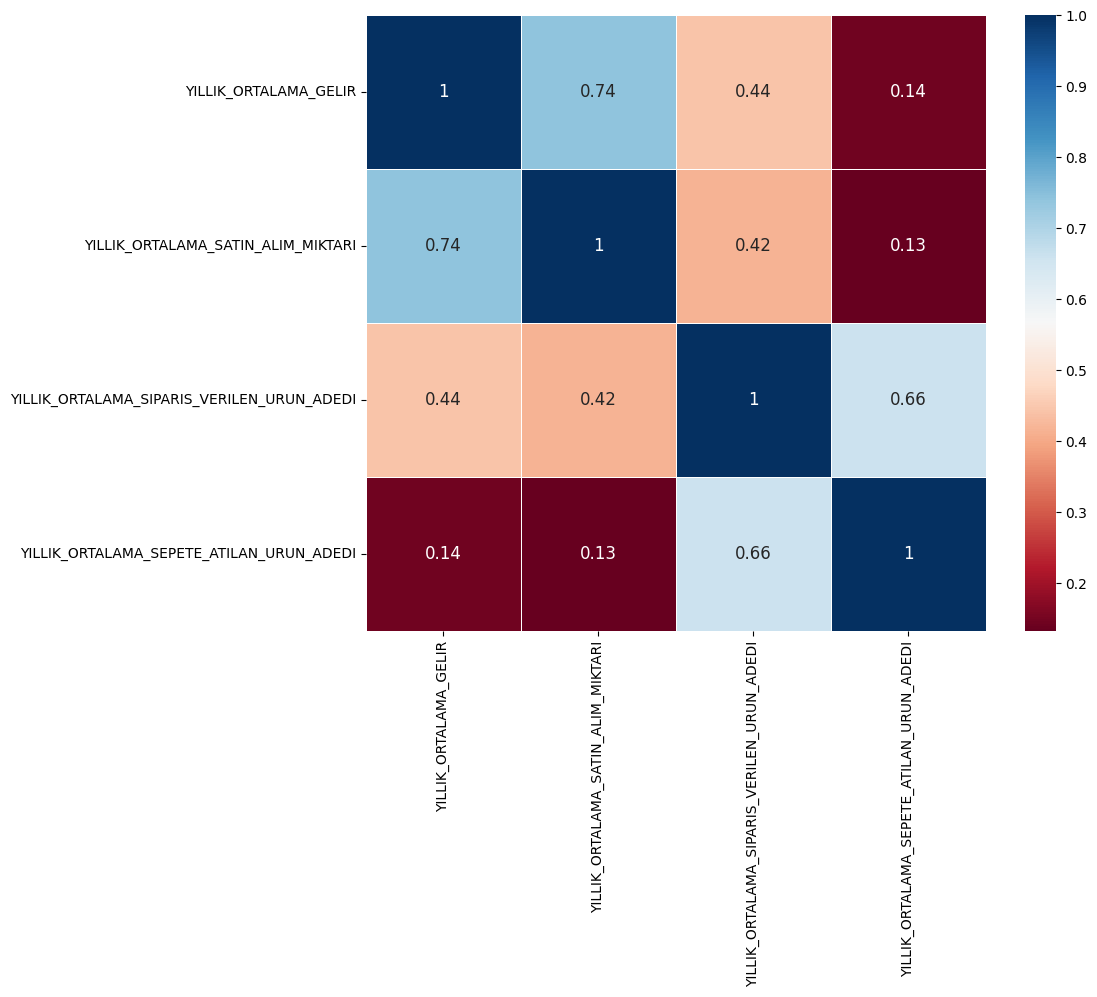

In [19]:
fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
fig = sns.heatmap(train_df[num_cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
plt.show(block=True)

Yüksek korelasyona sahip kolonlar gözlemlenmemiştir.

Test ve Train Veri Setlerindeki Numerik Değişkenlerin Dağılımını İnceleyelim.

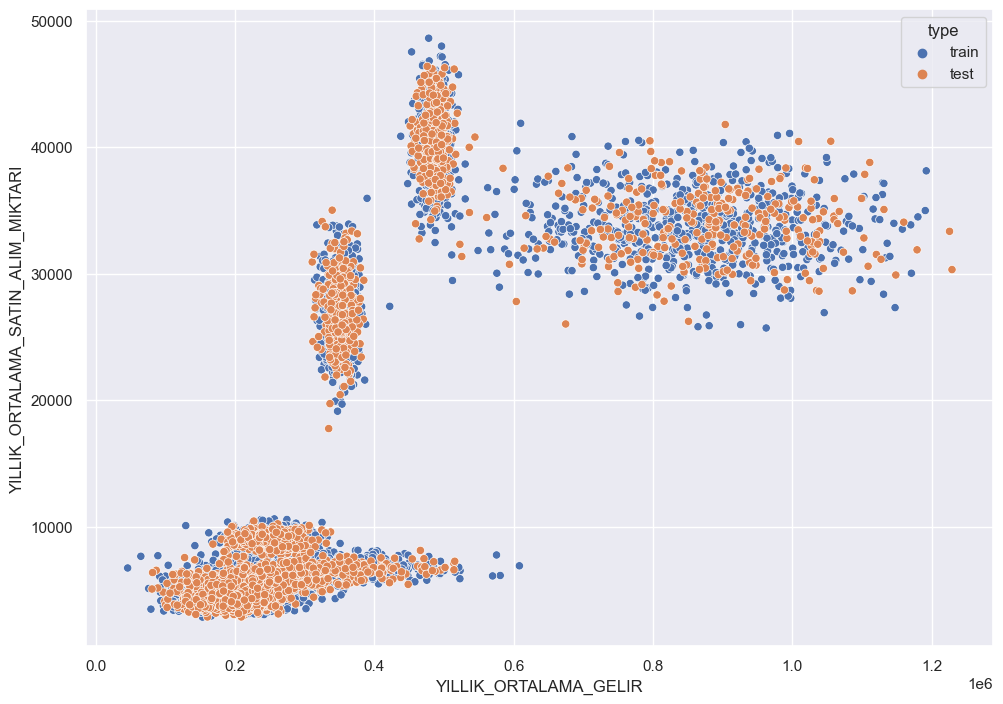

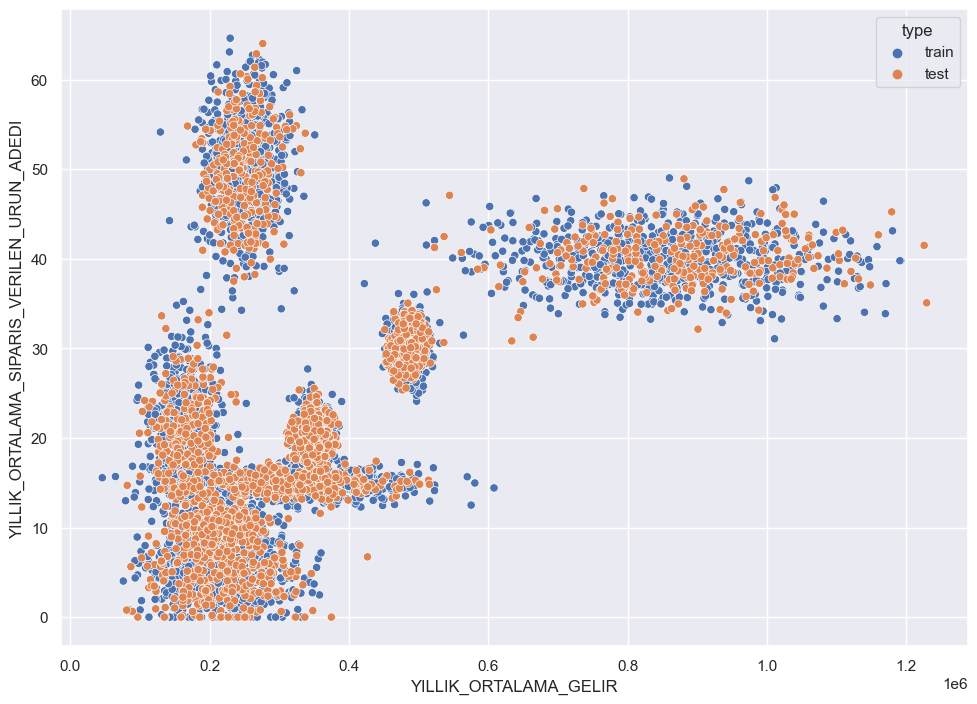

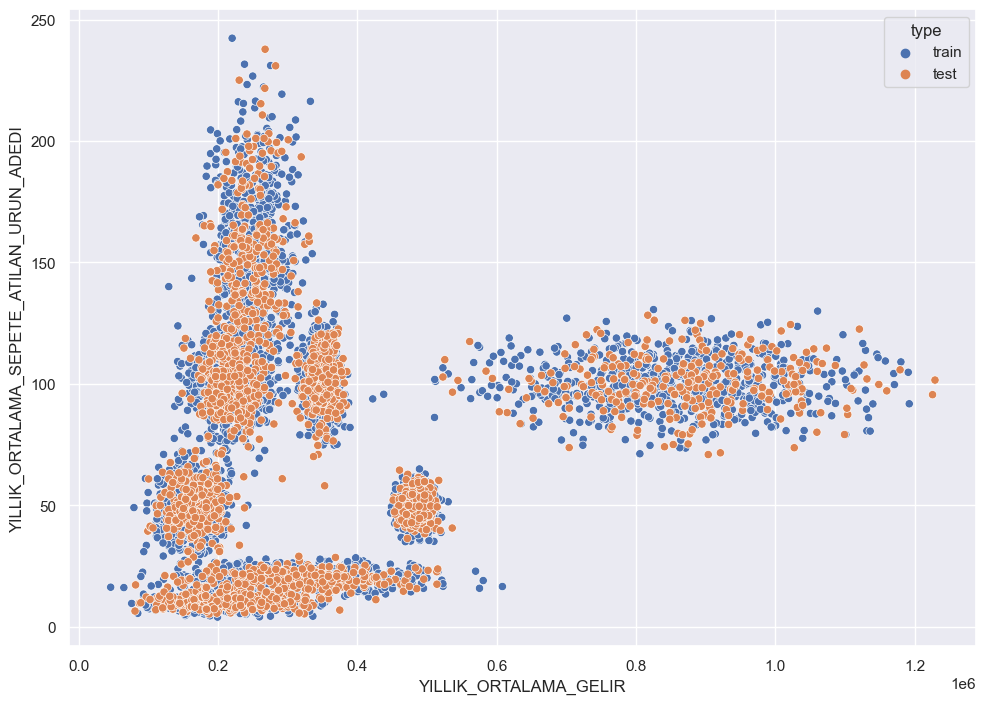

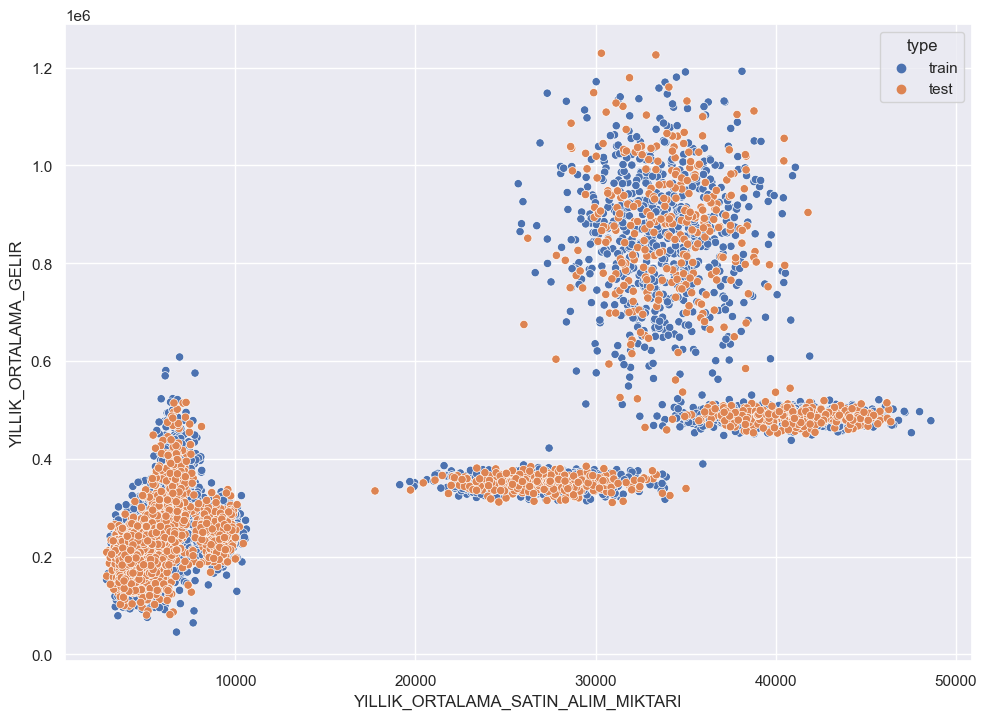

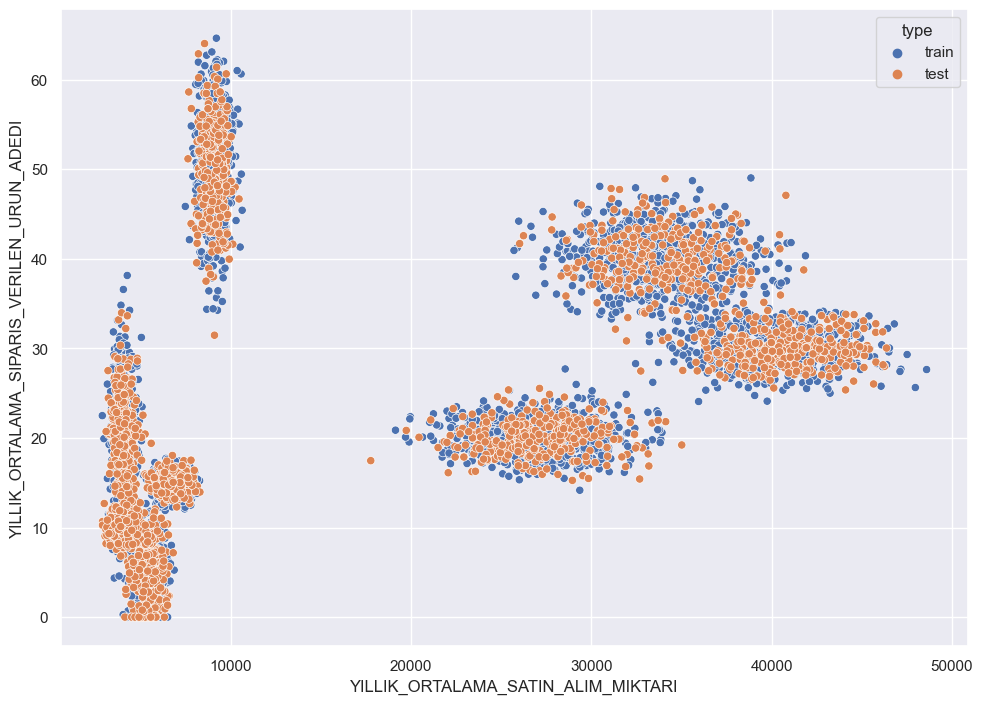

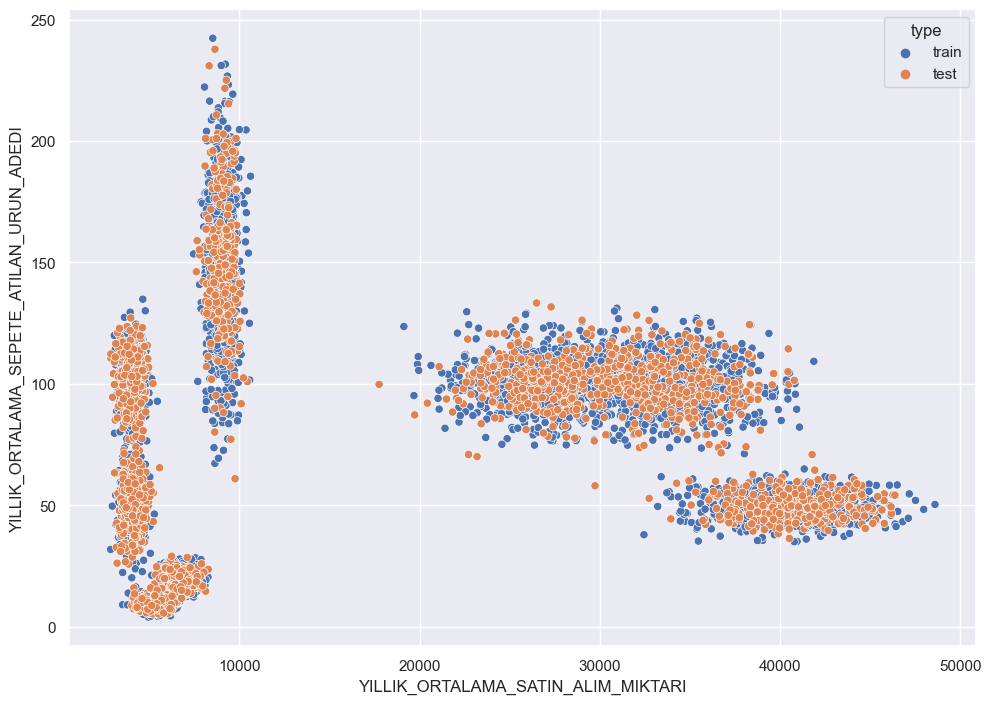

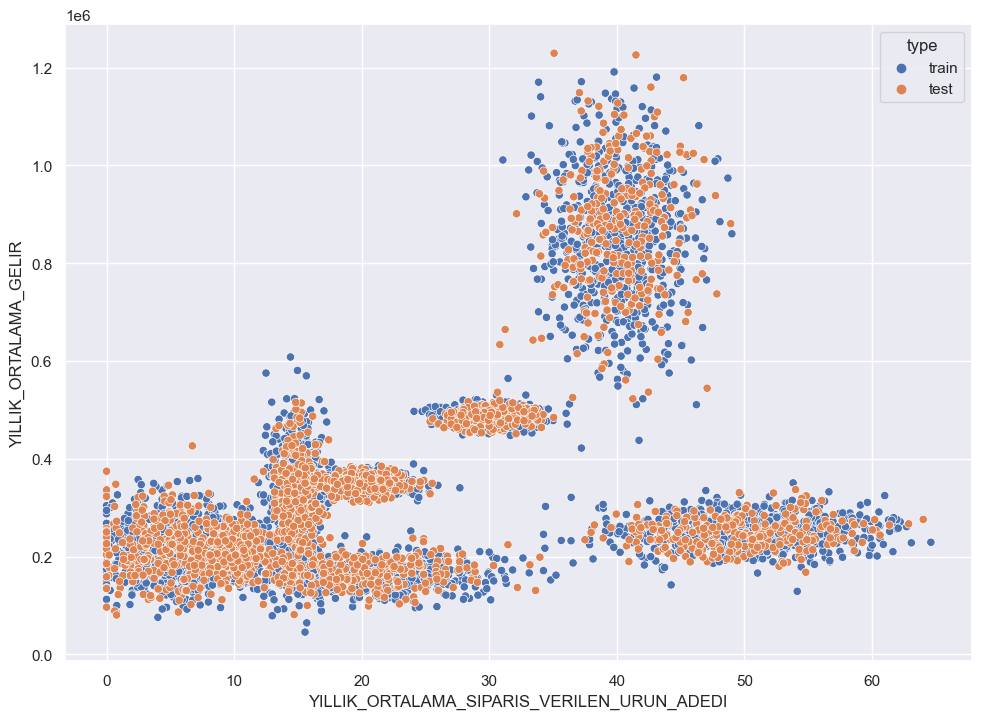

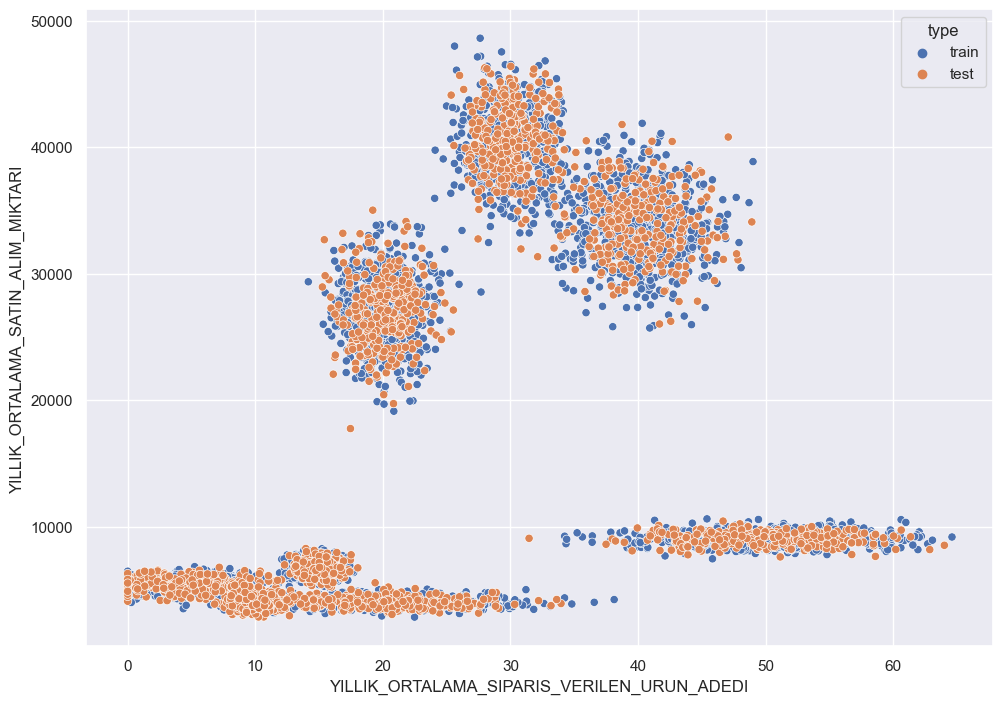

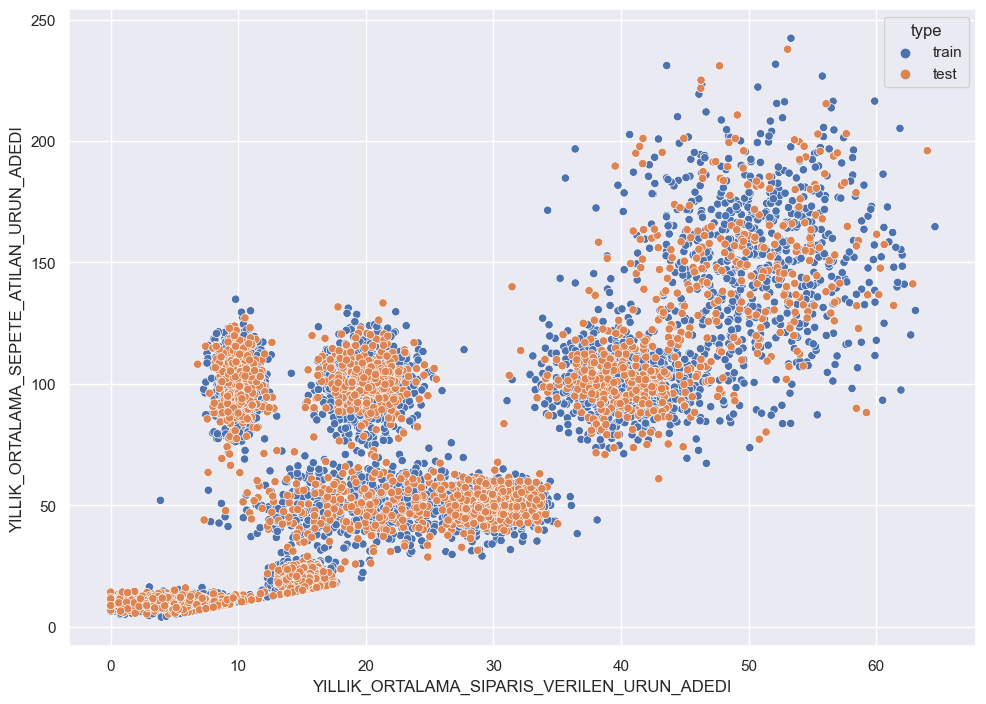

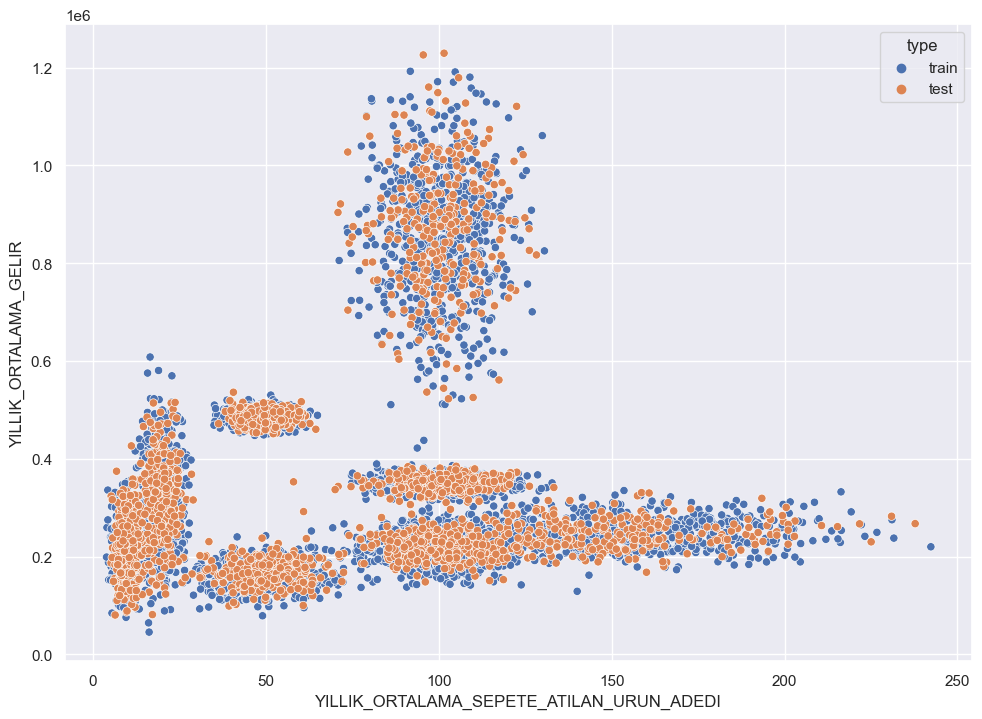

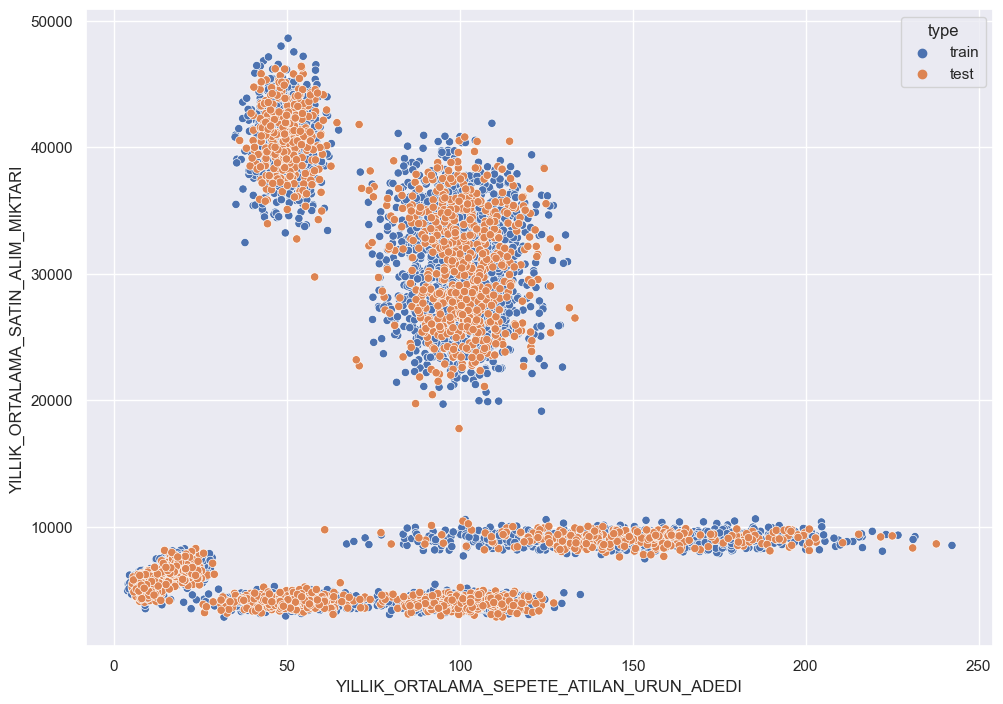

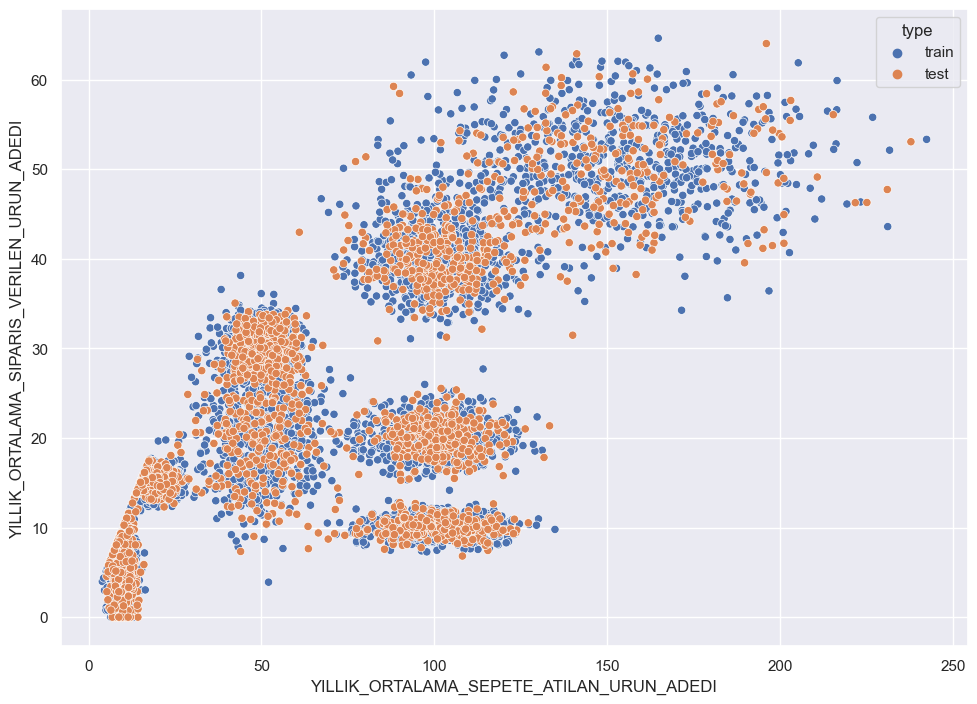

In [20]:
test_df = pd.read_csv("test_x.csv")
test_df = first_edit(test_df)
test_df.drop("INDEX",axis=1,inplace = True)

train_df["type"]="train"
test_df["type"]="test"

df = pd.concat([train_df, test_df])

for i in num_cols:
    for j in num_cols:
      if j==i:
        continue
      else:
        sns.set(rc={'figure.figsize':(11.7,8.27)})
        sns.scatterplot(data=df, x=i, y=j,hue="type")
        plt.show(block = True)

Yukarıda görmüş olduğumuz dağılımlar verinin içerisinde outlier değerlerin sürekli bir şekilde bulunduğunu gösteriyor. Bu da verinin doğal olup sonradan bozulmuş olabileceği ya da verinin sentetik olabileceği düşüncesini uyandırıyor.

## Groupby

Verideki gereksiz kolonları modele katmadan önce ve aynı zamanda yeni değişkenler üretmeden önce kolonların birbiri le ilişkisini groupby ile inceleyelim.

In [21]:
print(train_df.groupby("OBEK_ISMI")["YILLIK_ORTALAMA_SIPARIS_VERILEN_URUN_ADEDI"].mean())
print("\n")

print(train_df.groupby("OBEK_ISMI")["YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI"].mean())
print("\n")

print(train_df.groupby("OBEK_ISMI")["YILLIK_ORTALAMA_SATIN_ALIM_MIKTARI"].sum())
print("\n")

print(train_df.groupby("OBEK_ISMI")["YILLIK_ORTALAMA_GELIR"].median())
print("\n")

print(train_df.groupby(["OBEK_ISMI"])["ISTIHDAM_DURUMU"].value_counts())
print("\n")

print(train_df.groupby(["OBEK_ISMI"])["EN_COK_ILGILENDIGI_URUN_GRUBU"].value_counts())
print("\n")
print(train_df.groupby(["OBEK_ISMI"])["YASADIGI_SEHIR"].value_counts())
print("\n")

print(train_df.groupby(["OBEK_ISMI"])["CINSIYET"].value_counts())
print("\n")

print(train_df.groupby(["OBEK_ISMI"])["EGITIME_DEVAM_ETME_DURUMU"].value_counts())
print("\n")

print(train_df.groupby(["OBEK_ISMI"])["EGITIM_DUZEYI"].value_counts())
print("\n")

print(train_df.groupby(["OBEK_ISMI"])["MEDENI_DURUM"].value_counts())
print("\n")

print(train_df.groupby(["OBEK_ISMI"])["YAS_GRUBU"].value_counts())
print("\n")
print(train_df.groupby(["OBEK_ISMI", "CINSIYET"])["ISTIHDAM_DURUMU"].value_counts())

OBEK_ISMI
obek_1     4.983881
obek_2    20.226586
obek_3    14.889326
obek_4    39.899248
obek_5    10.085388
obek_6    30.002189
obek_7    20.156935
obek_8    50.096356
Name: YILLIK_ORTALAMA_SIPARIS_VERILEN_URUN_ADEDI, dtype: float64


OBEK_ISMI
obek_1     10.149700
obek_2     49.489618
obek_3     19.863289
obek_4    100.034046
obek_5    100.552187
obek_6     49.587777
obek_7     99.848963
obek_8    149.013874
Name: YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI, dtype: float64


OBEK_ISMI
obek_1    3.584529e+06
obek_2    2.198501e+06
obek_3    4.539654e+06
obek_4    2.318687e+07
obek_5    2.756382e+06
obek_6    2.680724e+07
obek_7    1.796895e+07
obek_8    6.258020e+06
Name: YILLIK_ORTALAMA_SATIN_ALIM_MIKTARI, dtype: float64


OBEK_ISMI
obek_1    219395.772325
obek_2    161554.645962
obek_3    330797.339772
obek_4    852011.085290
obek_5    216037.451413
obek_6    485216.556767
obek_7    350861.228314
obek_8    251154.995278
Name: YILLIK_ORTALAMA_GELIR, dtype: float64


OBEK_ISMI  ISTIHDAM

### Obek 1 :
Ortalama Sipariş Adedi: En düşük, 5.87 adet,
Ortalama Sepete Atılan Ürün Adedi: Orta düzeyde, 13.26 adet,
Ortalama Satın Alım Miktarı: Yüksek, 4.18 milyon birim,
Ortalama Gelir: Orta düzeyde, 222,240 TL,
İstihdam Durumu: Düzenli ve Ücretli Bir İşi Var (%), Kadınlar ve Erkekler benzer oranda,
En Çok İlgilendiği Ürün Grubu: Giyim,
Yaşadığı Şehir: Küçük Şehir,
Cinsiyet: Kadınlar ve Erkekler benzer oranda,
Eğitime Devam Etme Durumu: Etmiyor,
Eğitim Düzeyi: Lise Mezunu,
Medeni Durum: Evli,
Yaş Grubu: 18-30

### Obek 2 :
Ortalama Sipariş Adedi: Orta düzeyde, 20.66 adet,
Ortalama Sepete Atılan Ürün Adedi: Yüksek, 50.98 adet,
Ortalama Satın Alım Miktarı: Orta düzeyde, 2.73 milyon birim,
Ortalama Gelir: Yüksek, 162,411 TL,
İstihdam Durumu: İşsiz veya Düzenli Bir İşi Yok (%), Kadınlar ve Erkekler benzer oranda,
En Çok İlgilendiği Ürün Grubu: Giyim ve Ev ve Mobilya,
Yaşadığı Şehir: Küçük Şehir,
Cinsiyet: Kadınlar ve Erkekler benzer oranda,
Eğitime Devam Etme Durumu: Etmiyor,
Eğitim Düzeyi: Lise Mezunu,
Medeni Durum: Evli,
Yaş Grubu: 18-30

### Obek 3 :
Ortalama Sipariş Adedi: Orta düzeyde, 15.20 adet,
Ortalama Sepete Atılan Ürün Adedi: Orta düzeyde, 21.57 adet,
Ortalama Satın Alım Miktarı: Yüksek, 5.12 milyon birim,
Ortalama Gelir: Yüksek, 331,674 TL,
İstihdam Durumu: Düzenli ve Ücretli Bir İşi Var (%), Erkekler daha fazla,
En Çok İlgilendiği Ürün Grubu: Spor Malzemeleri ve Elektronik Ürünler,
Yaşadığı Şehir: Küçük Şehir,
Cinsiyet: Erkekler daha fazla,
Eğitime Devam Etme Durumu: Etmiyor,
Eğitim Düzeyi: Eğitimsiz,
Medeni Durum: Evli,
Yaş Grubu: 51-60

### Obek 4 :
Ortalama Sipariş Adedi: Yüksek, 38.89 adet,
Ortalama Sepete Atılan Ürün Adedi: Yüksek, 98.03 adet,
Ortalama Satın Alım Miktarı: Çok yüksek, 23.33 milyon birim,
Ortalama Gelir: Çok yüksek, 848,932 TL,
İstihdam Durumu: Düzenli ve Ücretli Bir İşi Var (%), Kadınlar ve Erkekler benzer oranda,
En Çok İlgilendiği Ürün Grubu: Giyim,
Yaşadığı Şehir: Büyük Şehir,
Cinsiyet: Kadınlar ve Erkekler benzer oranda,
Eğitime Devam Etme Durumu: Etmiyor,
Eğitim Düzeyi: Lise Mezunu,
Medeni Durum: Bekar,
Yaş Grubu: 31-40

### Obek 5 :
Ortalama Sipariş Adedi: Orta düzeyde, 10.70 adet,
Ortalama Sepete Atılan Ürün Adedi: Yüksek, 99.56 adet,
Ortalama Satın Alım Miktarı: Orta düzeyde, 3.21 milyon birim,
Ortalama Gelir: Orta düzeyde, 216,617 TL,
İstihdam Durumu: Düzenli ve Ücretli Bir İşi Var (%), Erkekler daha fazla,
En Çok İlgilendiği Ürün Grubu: Elektronik Ürünler,
Yaşadığı Şehir: Küçük Şehir,
Cinsiyet: Erkekler daha fazla,
Eğitime Devam Etme Durumu: Etmiyor,
Eğitim Düzeyi: Lise Mezunu,
Medeni Durum: Bekar,
Yaş Grubu: 31-40

### Obek 6 :
Ortalama Sipariş Adedi: Yüksek, 29.78 adet,
Ortalama Sepete Atılan Ürün Adedi: Orta düzeyde, 50.68 adet,
Ortalama Satın Alım Miktarı: Çok yüksek, 27.13 milyon birim,
Ortalama Gelir: Çok yüksek, 484,914 TL,
İstihdam Durumu: Emekli (%), Kadınlar ve Erkekler benzer oranda,
En Çok İlgilendiği Ürün Grubu: Ev ve Mobilya,
Yaşadığı Şehir: Köy veya Kasaba,
Cinsiyet: Kadınlar ve Erkekler benzer oranda,
Eğitime Devam Etme Durumu: Etmiyor,
Eğitim Düzeyi: Eğitimsiz,
Medeni Durum: Evli,
Yaş Grubu: 51-60

### Obek 7 :
Ortalama Sipariş Adedi: Yüksek, 20.28 adet,
Ortalama Sepete Atılan Ürün Adedi: Yüksek, 98.18 adet,
Ortalama Satın Alım Miktarı: Yüksek, 18.37 milyon birim,
Ortalama Gelir: Orta düzeyde, 350,565 TL,
İstihdam Durumu: Düzenli ve Ücretli Bir İşi Var (%), Kadınlar ve Erkekler benzer oranda,
En Çok İlgilendiği Ürün Grubu: Ev ve Mobilya,
Yaşadığı Şehir: Büyük Şehir,
Cinsiyet: Kadınlar ve Erkekler benzer oranda,
Eğitime Devam Etme Durumu: Etmiyor,
Eğitim Düzeyi: Lise Mezunu,
Medeni Durum: Evli,
Yaş Grubu: 31-40

### Obek 8 :
Ortalama Sipariş Adedi: Yüksek, 49.09 adet,
Ortalama Sepete Atılan Ürün Adedi: Yüksek, 146.42 adet,
Ortalama Satın Alım Miktarı: Orta düzeyde, 6.65 milyon birim,
Ortalama Gelir: Orta düzeyde, 251,651 TL,
İstihdam Durumu: Düzenli ve Ücretli Bir İşi Var (%), Kadınlar ve Erkekler benzer oranda,
En Çok İlgilendiği Ürün Grubu: Giyim,
Yaşadığı Şehir: Büyük Şehir,
Cinsiyet: Kadınlar ve Erkekler benzer oranda,
Eğitime Devam Etme Durumu: Ediyor,
Eğitim Düzeyi: Lise Mezunu,
Medeni Durum: Bekar,
Yaş Grubu: 18-30

## Feature Extraction

Veri incelendikten sonra gözlemler üzerine, var olan değişkenler üzerinden yeni değişkenler üretildi. Tüm test sırasında çok fazla değişken test edildi ve aşağıdaki iki tanesi faydalı bulundu.

In [22]:
train_df.loc[(train_df['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] < 14), "YENI_ORT_SEPET"] = 'CIMRI'
train_df.loc[(train_df['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] >= 14) & (train_df['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] <= 29), "YENI_ORT_SEPET"] = 'TUTUMLU'
train_df.loc[(train_df['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] >= 29) & (train_df['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] <= 50), "YENI_ORT_SEPET"] = 'NORMAL_INSAN'
train_df.loc[(train_df['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] >= 50) & (train_df['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] <= 100), "YENI_ORT_SEPET"] = 'VAR_KI_ALIYON'
train_df.loc[(train_df['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] > 100), "YENI_ORT_SEPET"] = 'MUSRIF'

train_df.loc[(train_df['YILLIK_ORTALAMA_GELIR'] < 400000), "YENI_ORT_GELIR"] = 'EH_ISTE'
train_df.loc[(train_df['YILLIK_ORTALAMA_GELIR'] >= 400000) & (train_df['YILLIK_ORTALAMA_GELIR'] <= 600000), "YENI_ORT_GELIR"] = 'YASIYORSUN_HAYATI'
train_df.loc[(train_df['YILLIK_ORTALAMA_GELIR'] > 600000), "YENI_ORT_GELIR"] = 'KOSEYI_DONMUS'

Aşağıdaki üretilen değişkenler yaptığımız testlerde accuracy üzerinde olumsuz etki oluşturduğu için eklenmedi.

In [23]:
# train_df.loc[(train_df['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] < 14), "YENI_KATEGORIK_DEGISKEN"] = 'CIMRI'
# train_df.loc[(train_df['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] >= 14) & (train_df['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] <= 29), "YENI_KATEGORIK_DEGISKEN"] = 'TUTUMLU'
# train_df.loc[(train_df['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] >= 29) & (train_df['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] <= 50), "YENI_KATEGORIK_DEGISKEN"] = 'NORMAL_INSAN'
# train_df.loc[(train_df['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] >= 50) & (train_df['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] <= 100), "YENI_KATEGORIK_DEGISKEN"] = 'VAR_KI_ALIYON'
# train_df.loc[(train_df['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] > 100), "YENI_KATEGORIK_DEGISKEN"] = 'MUSRIF'

# train_df.loc[(train_df['YILLIK_ORTALAMA_GELIR'] < 400000), "YENI_KATEGORIK_DEGISKEN"] += '_EH_ISTE'
# train_df.loc[(train_df['YILLIK_ORTALAMA_GELIR'] >= 400000) & (train_df['YILLIK_ORTALAMA_GELIR'] <= 600000), "YENI_KATEGORIK_DEGISKEN"] += '_YASIYORSUN_HAYATI'
# train_df.loc[(train_df['YILLIK_ORTALAMA_GELIR'] > 600000), "YENI_KATEGORIK_DEGISKEN"] += '_KOSEYI_DONMUS'

# train_df["YENI_SATIN_AL_GEL"] = train_df["YILLIK_ORTALAMA_SATIN_ALIM_MIKTARI"] / train_df["YILLIK_ORTALAMA_GELIR"]

# train_df["YENI_ORT_GEL_SEP"] = train_df["YILLIK_ORTALAMA_GELIR"] / train_df["YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI"]

# train_df["YENI_ORT_SIP_SEP"] = train_df["YILLIK_ORTALAMA_SIPARIS_VERILEN_URUN_ADEDI"] / train_df["YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI"]

# train_df["YENI_ALIM_GUCU"] = train_df["YILLIK_ORTALAMA_GELIR"] / train_df["YILLIK_ORTALAMA_SIPARIS_VERILEN_URUN_ADEDI"]
# train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# for obek in train_df["YENI_ORT_SEPET"].unique():
#   index = train_df[(train_df["YENI_ORT_SEPET"] == obek) & (train_df["YENI_ALIM_GUCU"].isna())].index
#   mean_value = train_df[train_df["YENI_ORT_SEPET"] == obek]["YENI_ALIM_GUCU"].mean()
#   train_df.loc[index, "YENI_ALIM_GUCU"] = mean_value
#   print(f"{obek} : {index}")

# train_df.loc[(train_df['YILLIK_ORTALAMA_SIPARIS_VERILEN_URUN_ADEDI'] < 8.5), "YENI_SIP_CAT"] = 'A'
# train_df.loc[(train_df['YILLIK_ORTALAMA_SIPARIS_VERILEN_URUN_ADEDI'] >= 8.5) & (train_df['YILLIK_ORTALAMA_SIPARIS_VERILEN_URUN_ADEDI'] <= 12), "YENI_SIP_CAT"] = 'B'
# train_df.loc[(train_df['YILLIK_ORTALAMA_SIPARIS_VERILEN_URUN_ADEDI'] >= 12) & (train_df['YILLIK_ORTALAMA_SIPARIS_VERILEN_URUN_ADEDI'] <= 16.5), "YENI_SIP_CAT"] = 'C'
# train_df.loc[(train_df['YILLIK_ORTALAMA_SIPARIS_VERILEN_URUN_ADEDI'] >= 16.5) & (train_df['YILLIK_ORTALAMA_SIPARIS_VERILEN_URUN_ADEDI'] <= 24.75), "YENI_SIP_CAT"] = 'D'
# train_df.loc[(train_df['YILLIK_ORTALAMA_SIPARIS_VERILEN_URUN_ADEDI'] >= 24.75) & (train_df['YILLIK_ORTALAMA_SIPARIS_VERILEN_URUN_ADEDI'] <= 34), "YENI_SIP_CAT"] = 'E'
# train_df.loc[(train_df['YILLIK_ORTALAMA_SIPARIS_VERILEN_URUN_ADEDI'] >= 34) & (train_df['YILLIK_ORTALAMA_SIPARIS_VERILEN_URUN_ADEDI'] <= 44.25), "YENI_SIP_CAT"] = 'F'
# train_df.loc[(train_df['YILLIK_ORTALAMA_SIPARIS_VERILEN_URUN_ADEDI'] >= 44.25), "YENI_SIP_CAT"] = 'STOKCU'

## Model Öncesi Son Hazırlıklar

Groupby'lara ve yaptığımız testlere göre eğitime devam etme durumunun hedef değişkene kayda değer bir etki yapmadığını gördük.
Bu sebeple bu sütünun veri setinden azad edilmesine karar verdik.
:)

In [24]:

cat_cols = [col for col in cat_cols if col not in ["EGITIME_DEVAM_ETME_DURUMU"]]
train_df.drop(["EGITIME_DEVAM_ETME_DURUMU"], axis=1,inplace=True)

Değişkenlerin Encode Edilmesi

In [25]:
cat_cols = [col for col in cat_cols if col not in ["OBEK_ISMI"]]
le = LabelEncoder()
train_df['OBEK_ISMI'] = le.fit_transform(train_df['OBEK_ISMI'])
train_df = pd.get_dummies(train_df, columns=cat_cols, drop_first=True)

Encode edildikten sonra verinin tekrar kontrol edilmesi:

In [26]:
print(train_df.head())

   YILLIK_ORTALAMA_GELIR  YILLIK_ORTALAMA_SATIN_ALIM_MIKTARI  YILLIK_ORTALAMA_SIPARIS_VERILEN_URUN_ADEDI  OBEK_ISMI  YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI   type YENI_ORT_SEPET YENI_ORT_GELIR  CINSIYET_Kadın  YAS_GRUBU_31-40  YAS_GRUBU_41-50  YAS_GRUBU_51-60  YAS_GRUBU_>60  MEDENI_DURUM_Evli  EGITIM_DUZEYI_Doktora Ötesi  EGITIM_DUZEYI_Eğitimsiz  EGITIM_DUZEYI_Lise Mezunu  EGITIM_DUZEYI_Ortaokul Mezunu  EGITIM_DUZEYI_Yüksek Lisans Mezunu  EGITIM_DUZEYI_Yüksekokul Mezunu  EGITIM_DUZEYI_Üniversite Mezunu  EGITIM_DUZEYI_İlkokul Mezunu  ISTIHDAM_DURUMU_Emekli  ISTIHDAM_DURUMU_Kendi İşinin Sahibi  ISTIHDAM_DURUMU_İşsiz veya Düzenli Bir İşi Yok  YASADIGI_SEHIR_Köy veya Kasaba  \
0          748266.440879                        32010.900881                                   37.310644          3                                102.936904  train         MUSRIF  KOSEYI_DONMUS            True             True            False            False          False              False                     

# Bütün İşlemlerin Fonksiyonlaştırılması

Train için yapılan tüm bu işlemleri otomatize hale getirelim. Bu şekilde aynı kodları birden fazla kere tekrarlamadan hem train hem test kümesinin ön işleme ve diğer adımlarını bir satırda yapabilecek duruma gelelim.

In [27]:
def data_prep(dataframe,test=True):
  #---------------------------DATAYI DUZENLEYELIM---------------------------
  first_edit(dataframe)

  #---------------------INDEX DEGISKENINI DROP EDELIM-------------------------
  dataframe.drop("INDEX",axis=1,inplace = True)

  #-------------------DEGISKENLERI TIPLERE GORE AYIRALIM----------------------
  cat_cols, num_cols = grab_col_names(dataframe)

  #--------------------------OUTLIER INCELEMESI-------------------------------
  # Burada egitim datasi mi yoksa test datasi mi o ayriliyor.
  # Eğer test datası ile bu blok çalışmayacak.
  if test==False:

    # Bir de LOF yontemiyle outlier incelemesi yapalim
    df = dataframe.select_dtypes(include=['float64', 'int64'])
    clf = LocalOutlierFactor(n_neighbors=20)
    clf.fit_predict(df)
    df_scores = clf.negative_outlier_factor_
    df_scores[0:5]
    # df_scores = -df_scores
    np.sort(df_scores)[0:5]

    th = np.sort(df_scores)[3]

    #Outlier degerler drop ediliyor
    dataframe.drop(index=df[df_scores < th].index, inplace=True)

    # "diffrent_outlier" fonksiyonu yardımı ile outlier bulalım.
    indices = []
    for col in num_cols:
      indices.extend(diffrent_outlier(dataframe, col,"OBEK_ISMI"))
    indices = set(indices)
    print(f"outlier sayısı {len(indices)} ")
    # Outlier'lar veri setinden drop ediliyor
    dataframe.drop(index=indices, inplace=True)

  #---------------------------FEATURE EXTRACTION-------------------------------
  # YENI_ORT_SEPET
  dataframe.loc[(dataframe['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] < 14), "YENI_ORT_SEPET"] = 'CIMRI'
  dataframe.loc[(dataframe['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] >= 14) & (dataframe['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] <= 29), "YENI_ORT_SEPET"] = 'TUTUMLU'
  dataframe.loc[(dataframe['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] >= 29) & (dataframe['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] <= 50), "YENI_ORT_SEPET"] = 'NORMAL_INSAN'
  dataframe.loc[(dataframe['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] >= 50) & (dataframe['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] <= 100), "YENI_ORT_SEPET"] = 'VAR_KI_ALIYON'
  dataframe.loc[(dataframe['YILLIK_ORTALAMA_SEPETE_ATILAN_URUN_ADEDI'] > 100), "YENI_ORT_SEPET"] = 'MUSRIF'
  # YENI_ORT_GELIR
  dataframe.loc[(dataframe['YILLIK_ORTALAMA_GELIR'] < 400000), "YENI_ORT_GELIR"] = 'EH_ISTE'
  dataframe.loc[(dataframe['YILLIK_ORTALAMA_GELIR'] >= 400000) & (dataframe['YILLIK_ORTALAMA_GELIR'] <= 600000), "YENI_ORT_GELIR"] = 'YASIYORSUN_HAYATI'
  dataframe.loc[(dataframe['YILLIK_ORTALAMA_GELIR'] > 600000), "YENI_ORT_GELIR"] = 'KOSEYI_DONMUS'

  cat_cols, num_cols = grab_col_names(dataframe)

  #-----------------------MODEL ONCESI SON HAZIRLIK--------------------------
  cat_cols = [col for col in cat_cols if col not in ["EGITIME_DEVAM_ETME_DURUMU"]]
  dataframe.drop(["EGITIME_DEVAM_ETME_DURUMU"], axis=1,inplace=True)

  if test:
    dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=True)
  else:
    cat_cols = [col for col in cat_cols if col not in ["OBEK_ISMI"]]
    le = LabelEncoder()
    dataframe['OBEK_ISMI'] = le.fit_transform(dataframe['OBEK_ISMI'])
    dataframe = pd.get_dummies(dataframe, columns=cat_cols, drop_first=True)
  print(cat_cols)
  return cat_cols, num_cols, dataframe

Yapılan işleri otomatize hale getiren bu fonksiyonu train ve test verimiz için çağıralım

In [28]:
test_df = pd.read_csv("test_x.csv")
cat_test_cols, num_test_cols, test_df = data_prep(test_df)

print("\n################################################\n")

train_df = pd.read_csv("train.csv")
cat_cols, num_cols, train_df = data_prep(train_df, test=False)

Observations: 2340
Variables: 12
cat_cols: 8
num_cols: 4
cat_but_car: 0
num_but_cat: 0
Observations: 2340
Variables: 14
cat_cols: 10
num_cols: 4
cat_but_car: 0
num_but_cat: 0
['CINSIYET', 'YAS_GRUBU', 'MEDENI_DURUM', 'EGITIM_DUZEYI', 'ISTIHDAM_DURUMU', 'YASADIGI_SEHIR', 'EN_COK_ILGILENDIGI_URUN_GRUBU', 'YENI_ORT_SEPET', 'YENI_ORT_GELIR']

################################################

Observations: 5460
Variables: 13
cat_cols: 9
num_cols: 4
cat_but_car: 0
num_but_cat: 0

YILLIK_ORTALAMA_GELIR Kolonundaki öbeklere göre outlier sayısı : 
{'obek_4': 21, 'obek_5': 8, 'obek_8': 7, 'obek_3': 4, 'obek_6': 20, 'obek_1': 8, 'obek_7': 12, 'obek_2': 9}
YILLIK_ORTALAMA_GELIR Kolonundaki toplam outlier sayısı : 89
##############################


YILLIK_ORTALAMA_SATIN_ALIM_MIKTARI Kolonundaki öbeklere göre outlier sayısı : 
{'obek_4': 35, 'obek_5': 10, 'obek_8': 10, 'obek_3': 15, 'obek_6': 17, 'obek_1': 17, 'obek_7': 26, 'obek_2': 16}
YILLIK_ORTALAMA_SATIN_ALIM_MIKTARI Kolonundaki toplam outlier

## Model Parametreleri ve Modellerin Çalıştırılması

Buraya yazılan parametreler burada olan her model için sırasıyla denendi. Test verisinde En yüksek accuracy veren xgboost kullanılmasına karar verildi. Aşağıdaki parametreler dışında farklı parametreler ayrıca denendi ama kod çalışma zamanının çok uzamaması ve kodda karışıklığa sebep olamaması için eklenmedi.

In [29]:
knn_params = {"n_neighbors": range(2, 50)}

cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [10, 11, None],
             "max_features": [7, 8, "sqrt"],
             "min_samples_split": [17,18,19],
             "n_estimators": [220,230,240]}

xgboost_params = {"learning_rate": [0.1],
                  "max_depth": [4,5,6],
                  "n_estimators": [50,60,70],
                  "colsample_bytree": [0.5],
                  "objective": ['multi:softmax'],
                  "num_class":[8]}

lightgbm_params = {"learning_rate": [0.01,0.1],
                   "n_estimators": [400,500],
                   "colsample_bytree": [0.7, 1]}


classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(max_features='sqrt'), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(verbose = -1), lightgbm_params)]


### Hiperparametre Optimizasyon Fonksiyonu ve Model Seçimi

In [30]:
def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
  """
  Grid search ile daha önce belirlenen parametreler ile hiperparametre optimizasyonu yapılıyor.
  """
  print("Hyperparameter Optimization....")
  best_models = {}
  for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
  return best_models

Yazmış olduğumuz "hyperparameter_optimization" fonksiyonu ile belirlediğimiz modeller arasındaki en iyi parametreleri bulalım.

In [31]:
y = train_df["OBEK_ISMI"]
X = train_df.drop(["OBEK_ISMI"], axis=1)

# Train Verimizi modele verebilmek için scale edelim.
X_scaled = StandardScaler().fit_transform(X)

X = pd.DataFrame(X_scaled, columns=X.columns)

best_model = hyperparameter_optimization(X,y,scoring="accuracy")

Hyperparameter Optimization....
########## KNN ##########
accuracy (Before): 0.9358
accuracy (After): 0.9398
KNN best params: {'n_neighbors': 7}

########## CART ##########
accuracy (Before): 0.9876
accuracy (After): 0.9922
CART best params: {'max_depth': 7, 'min_samples_split': 22}

########## RF ##########
accuracy (Before): 0.9952
accuracy (After): 0.9952
RF best params: {'max_depth': 10, 'max_features': 7, 'min_samples_split': 17, 'n_estimators': 220}

########## XGBoost ##########
accuracy (Before): 0.9943
accuracy (After): 0.9952
XGBoost best params: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'num_class': 8, 'objective': 'multi:softmax'}

########## LightGBM ##########
accuracy (Before): 0.9946
accuracy (After): 0.9946
LightGBM best params: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'n_estimators': 400}



Modelimizi kuralım.

In [32]:
# Test verimizi modele tahmin edebilmesi için scale edelim
X_scaled_test = StandardScaler().fit_transform(test_df)

X_test = pd.DataFrame(X_scaled_test, columns=test_df.columns)

best_xgb_params = best_model["XGBoost"].get_params()

"""
-Kendi bilgisayarımızda yaptığımız testler sonucu elde ettiğimiz parametreleri
  buraya ekleyeceğiz.
-Bu sebeple best_xgb_params değerlerini kullanmadık.
-Diffrent outlier fonksiyonundaki std parametresi ile yaptığımız testler sonucu
  daha uygun parametreler elde ettik.
# """
# model = XGBClassifier(**best_xgb_params).fit(X, y)

model = XGBClassifier(colsample_bytree = 0.5, learning_rate = 0.1, max_depth = 6,min_child_weight=4, n_estimators = 74, num_class = 8, objective = ["multi:softmax"]).fit(X,y)
y_pred = model.predict(X_test)

sample_df = sample_sub(y_pred)

sample_df.to_csv("son_submission.csv",index=False)

 Biz submissionlarımızı yaparken lightgbm, xgboost ve random forest algoritmalarını kullandık. Yukarıda yazan diğer algoritmalarla cross validation yöntemi ile test amaçlı accuracy hesaplaması yaptık. En yüksek accuracy değerini xgboost algoritması ile elde ettik. Bu sebeple yukarıda xgboost algoritması ile daha önce test edilmiş parametreler ile modeli kurduk.

sample_sub fonksiyonu ile y_pred listemizi dataframe haline getirdik ve submission.csv olarak aynı dizine kaydettik.

Kullanılmasına karar verilen model ve parametreler için feature importance grafiğini çizdirelim.

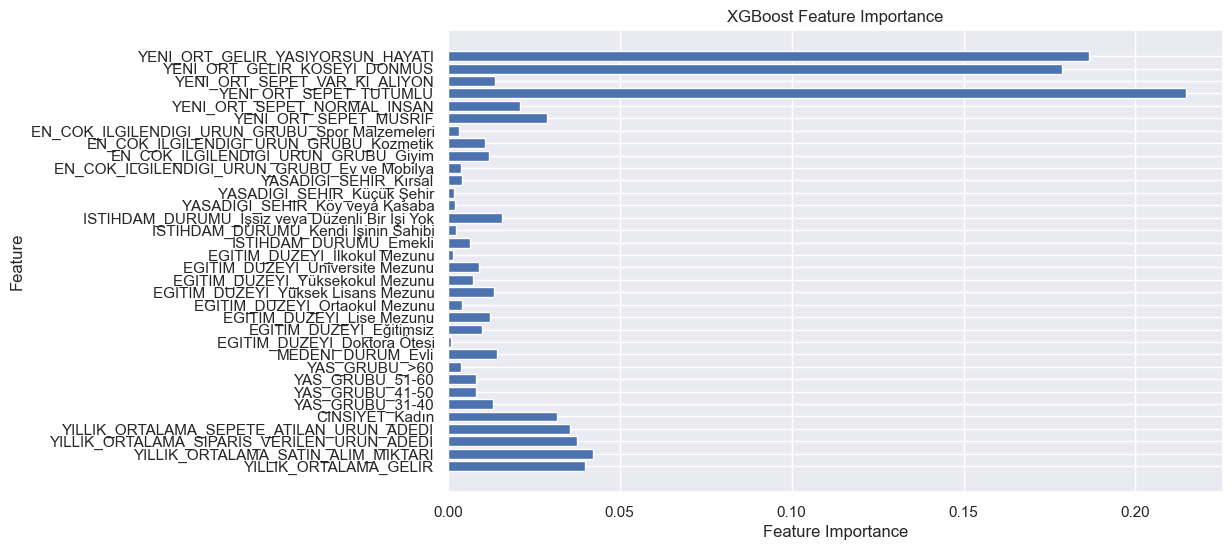

In [33]:
importance_values = model.feature_importances_
feature_names = model.feature_names_in_

plt.figure(figsize=(10, 6))
plt.barh(range(len(importance_values)), importance_values, align="center")
plt.yticks(range(len(importance_values)), feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.show()

Kendi testlerimiz esnasında en son yapmış olduğumuz submission ile şuan tahmin değerimiz olan y_pred arasında accuracy hesaplattık. Eğer en son yaptığımız submission ile aynı sonuçlar geldiyse günlük hakkımızı kullanmamak adına platforma yeni .csv dosyası yüklemedik.

In [34]:
y_test = pd.read_csv("submission_3.csv")

accuracy = accuracy_score(y_test["Öbek İsmi"], sample_df["Öbek İsmi"])

print("Accuracy:", accuracy)

Accuracy: 0.9982905982905983


**Kapanış Notu:**

Bu Notebook, Datathon 2023 için hazırlanmıştır. Bu çalışma, veri analizi ve model oluşturma sürecini adım adım açıklamak ve sonuçları sunmak amacıyla oluşturulmuştur.

Çalışma boyunca, veri keşfi, veri temizleme, özellik mühendisliği ve model eğitimi gibi önemli adımları ele aldık.

Sonuç olarak, bu çalışmanın yarışma hedeflerini başarıyla ele aldığını düşünüyoruz ve daha fazla iyileştirme veya geliştirme için potansiyel fırsatlar bulunmaktadır.

Herhangi bir geri bildiriminiz veya sorunuz varsa, lütfen iletişime geçmekten çekinmeyin.

Teşekkür ederiz!